Требуется решить интегральное уравнение первого рода типа Фредгольма.
По заданным функциям K(t,s)=e^(ts/2) и f(t) необходимо найти q(s), 

Решение.
Обозначим: S=3,T=1.
Дискретизируем область [0,S]×[0,T], построив на каждом интервале равномерную сетку для узлов N=N_t=N_S=8,16,32,64,512,1024,2048,4096.
Для вычисления интеграла используем квадратурную формулу Симпосона.
Обозначим:
	A_ij=K(t_i,s_j ) w_j
	q_j=q(s_j)
	f_i=f(t_i )
Получаем СЛАУ : Aq=f

In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

# kernel 
def K(t, s):
    return np.exp((t * s) / 2)

# exact q(s) 
def q_exact(s):
    s = np.asarray(s)
    q = np.zeros_like(s)
    mask1 = (s >= 0) & (s <= 2)
    mask2 = (s > 2) & (s <= 3)
    q[mask1] = (1 - s[mask1] / 2)**2
    q[mask2] = (s[mask2] / 2 - 1)**3
    return q


# weights
def build_weights(a, b, N):
    s = np.linspace(a, b, N)
    h = (b - a) / (N - 1)
    w = np.zeros(N)

    if (N - 1) % 2 == 0:
        w[0] = h/3
        w[1:-1:2] = 4*h/3
        w[2:-1:2] = 2*h/3
        w[-1] = h/3
        method = "Simpson"
    else:
        w[0] = h/2
        w[1:-1] = h
        w[-1] = h/2
        method = "Trapezoid"

    return s, w


# build A
def build_A_simpson(t_grid, s_grid, w):
    T, S = np.meshgrid(t_grid, s_grid, indexing='ij')
    return K(T, S) * w[np.newaxis, :]

# f exact
def compute_f_exact(t_grid, s_grid, w):
    Q = q_exact(s_grid)
    f = np.array([np.sum(K(t, s_grid) * Q * w) for t in t_grid])
    return f

# number of nodes
N_list = [8, 16, 32, 64, 128, 256, 512, 1024,2048]
# N_list = [9, 17, 33, 65, 129, 257, 513, 1025]




1. Исследовать сходимость вычисленного решения к точному решению при увеличении числа узлов сетки. Изучение поведения сингулярных чисел СЛАУ, аппроксимирующей уравнение для разного количества узлов сетки.
Для решения СЛАУ использовался метод SVD.

N,	error,	cond
8	1.10e-05	2.30e+11
16	4.78e+00	5.00e+18
32	9.26e-01	1.66e+16
64	1.96e+00	2.70e+16
128	3.60e+00	4.41e+16
256	4.58e+00	4.30e+16
512	7.83e+00	4.08e+16
1024	4.83e+00	3.20e+16
2048	5.97e+00	4.18e+16


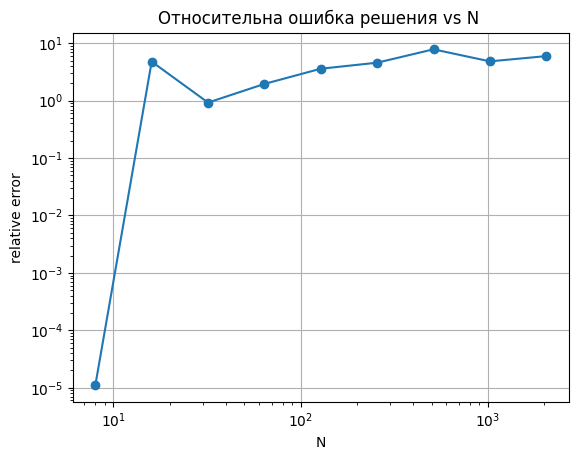

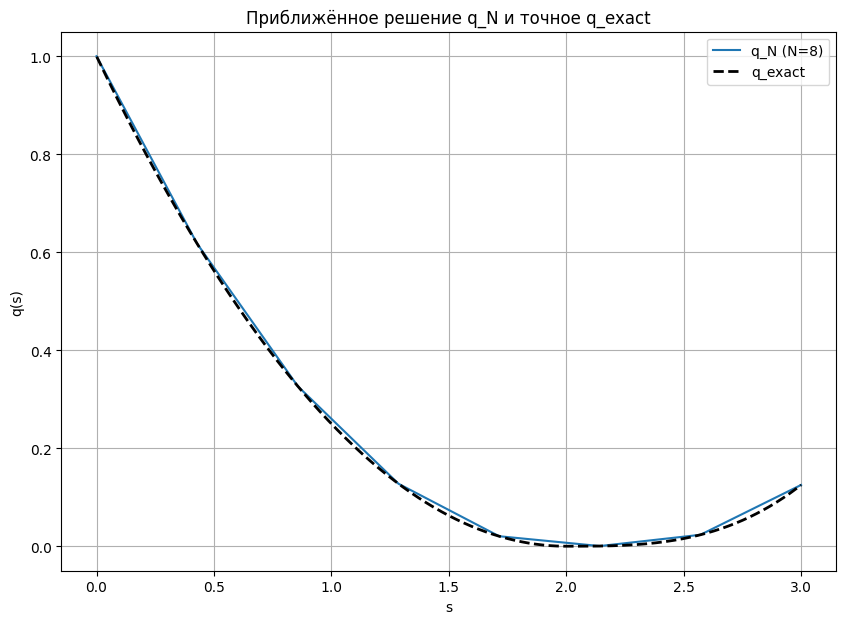

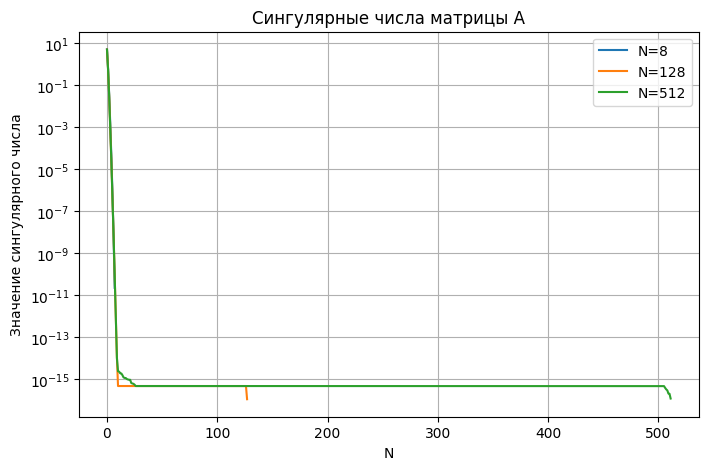

In [6]:
errors = []
conds = []
singulars = {}
solutions = {}

print(f"N,\terror,\tcond")
for N in N_list:

    s_grid, w = build_weights(0, 3, N)

    t_grid = np.linspace(0, 1, N)

    A = build_A_simpson(t_grid, s_grid, w)
    f = compute_f_exact(t_grid, s_grid, w)
    
    U, svals, Vt = la.svd(A, full_matrices=False)
    singulars[N] = svals
    
    s_inv = np.array([1/s for s in svals]) # SVD
    qN = Vt.T @ (s_inv * (U.T @ f))

    solutions[N] = (s_grid, qN)
    
    err = la.norm(qN - q_exact(s_grid)) / la.norm(q_exact(s_grid))
    errors.append(err)
    conds.append(svals[0]/svals[-1])

    print(f"{N}\t{err:.2e}\t{conds[-1]:.2e}")

# Графики относительной ошибки в зависимости от числа узлов
plt.loglog(N_list, errors, '-o')
plt.grid(True)
plt.title("Относительна ошибка решения vs N ")
plt.xlabel("N")
plt.ylabel("relative error")
plt.show()


N_plot = [8]
plt.figure(figsize=(10, 7))
for N in N_plot:
    s_grid, qN = solutions[N]
    plt.plot(s_grid, qN, label=f"q_N (N={N})")
s_fine = np.linspace(0.001, 3, 2000)
plt.plot(s_fine, q_exact(s_fine), 'k--', linewidth=2, label="q_exact")
plt.grid(True)
plt.xlabel("s")
plt.ylabel("q(s)")
plt.title("Приближённое решение q_N и точное q_exact")
plt.legend()
plt.show()

# График сингулярных чисел в зависимости от числа узлов сетки
N_plot = [8,128,512]
plt.figure(figsize=(8,5))
for N in N_plot:
    plt.semilogy(singulars[N], label=f"N={N}")
plt.grid(True)
plt.legend()
plt.xlabel("N")
plt.ylabel("Значение сингулярного числа")
plt.title("Сингулярные числа матрицы A")
plt.show()


1. Исследовать сходимость вычисленного решения к точному решению при увеличении числа узлов сетки. Изучение поведения сингулярных чисел СЛАУ, аппроксимирующей уравнение для разного количества узлов сетки.
Для решения СЛАУ использовался метод TSVD.

N,	error,	cond
8	1.10e-05	2.30e+11
16	3.07e-02	5.00e+18
32	9.99e-02	1.66e+16
64	1.26e-01	2.70e+16
128	1.08e-01	4.41e+16
256	8.36e-02	4.30e+16
512	6.05e-02	4.08e+16
1024	6.12e-02	3.20e+16
2048	3.03e-02	4.18e+16


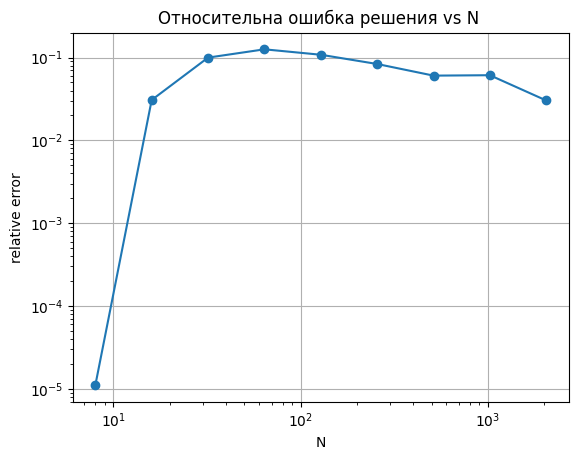

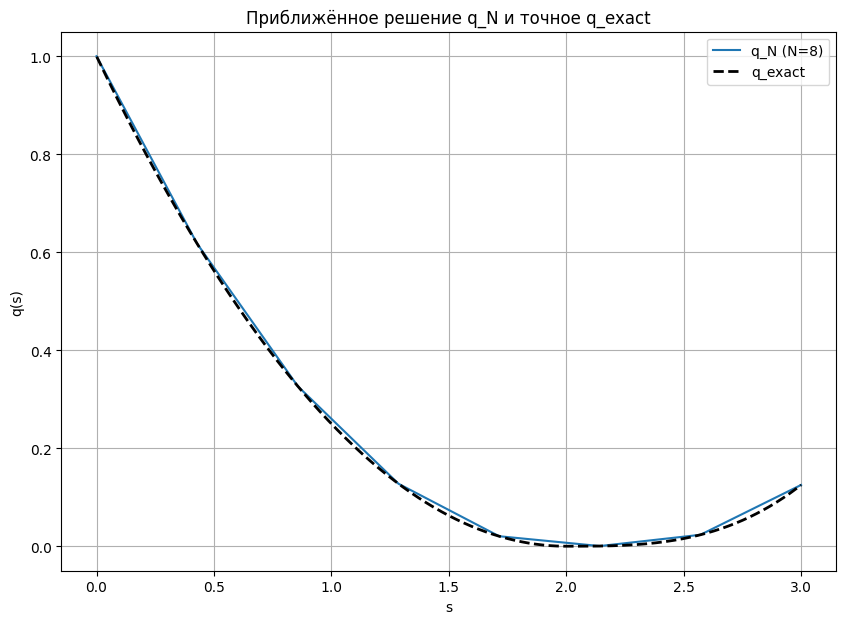

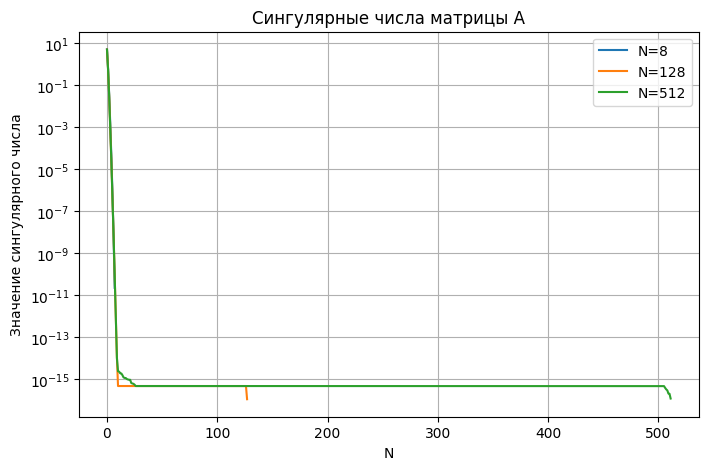

In [26]:
errors = []
conds = []
singulars = {}
solutions = {}

print(f"N,\terror,\tcond")
for N in N_list:

    s_grid, w = build_weights(0, 3, N)

    t_grid = np.linspace(0, 1, N)

    A = build_A_simpson(t_grid, s_grid, w)
    f = compute_f_exact(t_grid, s_grid, w)
    
    U, svals, Vt = la.svd(A, full_matrices=False)
    singulars[N] = svals

    rcond = 1e-15
    bound = rcond * svals[0]
    s_inv = np.array([1/s if s > bound else 0 for s in svals]) # TSVD
    qN = Vt.T @ (s_inv * (U.T @ f))

    solutions[N] = (s_grid, qN)
    
    err = la.norm(qN - q_exact(s_grid)) / la.norm(q_exact(s_grid))
    errors.append(err)
    conds.append(svals[0]/svals[-1])

    print(f"{N}\t{err:.2e}\t{conds[-1]:.2e}")

# Графики относительной ошибки в зависимости от числа узлов
plt.loglog(N_list, errors, '-o')
plt.grid(True)
plt.title("Относительна ошибка решения vs N ")
plt.xlabel("N")
plt.ylabel("relative error")
plt.show()


N_plot = [8]
plt.figure(figsize=(10, 7))
for N in N_plot:
    s_grid, qN = solutions[N]
    plt.plot(s_grid, qN, label=f"q_N (N={N})")
s_fine = np.linspace(0.001, 3, 2000)
plt.plot(s_fine, q_exact(s_fine), 'k--', linewidth=2, label="q_exact")
plt.grid(True)
plt.xlabel("s")
plt.ylabel("q(s)")
plt.title("Приближённое решение q_N и точное q_exact")
plt.legend()
plt.show()

# График сингулярных чисел в зависимости от числа узлов сетки
N_plot = [8,128,512]
plt.figure(figsize=(8,5))
for N in N_plot:
    plt.semilogy(singulars[N], label=f"N={N}")
plt.grid(True)
plt.legend()
plt.xlabel("N")
plt.ylabel("Значение сингулярного числа")
plt.title("Сингулярные числа матрицы A")
plt.show()


2. Исследовать зависимость численного решения при добавлении шума в данные (рассмотреть уровни шума 0.5, 1, 3 процента) (при фиксированном количестве узлов сетки).

Уровень шума (%) 	 Относительная ошибка
0.5%	8.50e+12
1.0%	1.62e+13
3.0%	5.02e+13


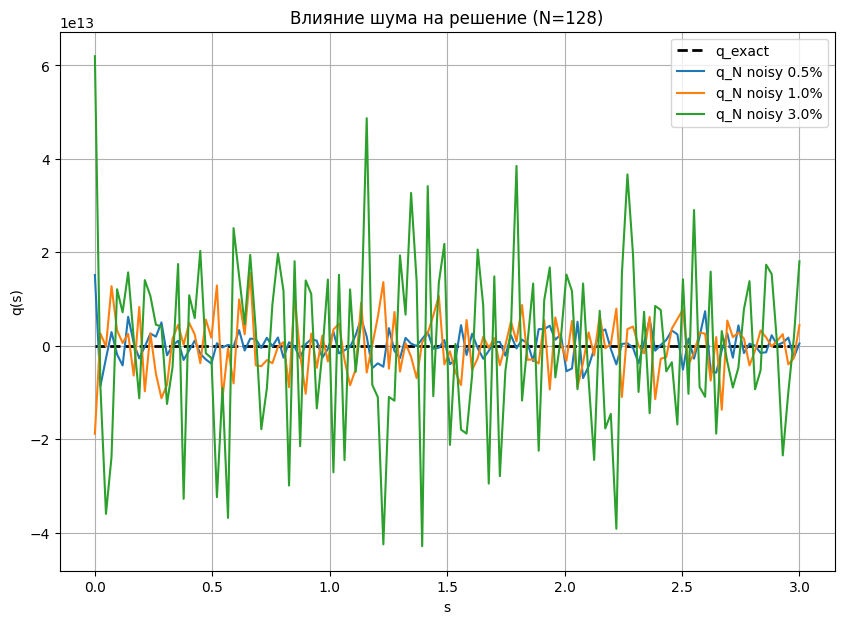

In [ ]:

N_noise = 128

noise_levels = [0.005, 0.01, 0.03]  # 0.5%, 1%, 3%

s_grid, w = build_weights(0, 3, N_noise)
t_grid = np.linspace(0, 1, N_noise)

# матрица A и точный f
A = build_A_simpson(t_grid, s_grid, w)
f_exact = compute_f_exact(t_grid, s_grid, w)

U, svals, Vt = la.svd(A, full_matrices=False)

# rcond = 1e-15
# bound = rcond * svals[0]
# s_inv = np.array([1/s if s > bound else 0 for s in svals]) # TSVD

s_inv = np.array([1/s for s in svals]) # SVD


print("Уровень шума (%) \t Относительная ошибка")
np.random.seed(0)
solutions_noisy = {}
for delta in noise_levels:
    alpha = np.random.rand(N_noise)
    f_noisy = f_exact + delta * alpha
    qN_noisy = Vt.T @ (s_inv * (U.T @ f_noisy))
    solutions_noisy[delta] = qN_noisy
    
    err = la.norm(qN_noisy - q_exact(s_grid)) / la.norm(q_exact(s_grid))
    print(f"{delta*100:.1f}%\t{err:.2e}")


plt.figure(figsize=(10,7))
plt.plot(s_grid, q_exact(s_grid), 'k--', linewidth=2, label="q_exact")
for nl, qN_noisy in solutions_noisy.items():
    plt.plot(s_grid, qN_noisy, label=f"q_N noisy {nl*100:.1f}%")
plt.xlabel("s")
plt.ylabel("q(s)")
plt.title(f"Влияние шума на решение (N={N_noise})")
plt.grid(True)
plt.legend()
plt.show()




3. Показать результат применения метода усечённого сингулярного разложения (рассмотреть для уровней шума в 0.5 и 3 процента). Изучить поведение решение и ошибки в зависимости от параметра, отвечающего за границу отсечения сингулярных значений.

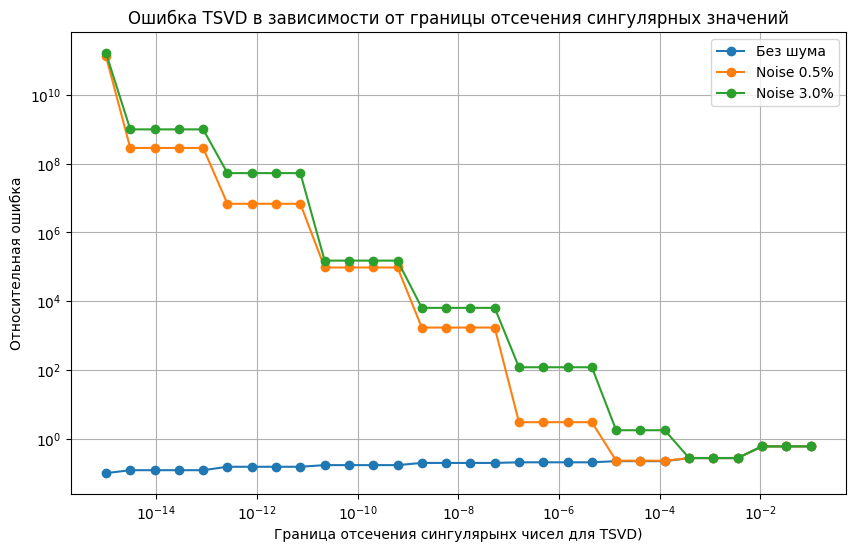


 Значение границы отсечения сингулярных чсиел при минимальной относительной ошибке
Без шума: rcond = 1.000e-15, error = 9.987e-02
Noise 0.5%: rcond = 1.374e-05, error = 2.291e-01
Noise 3.0%: rcond = 3.857e-04, error = 2.755e-01


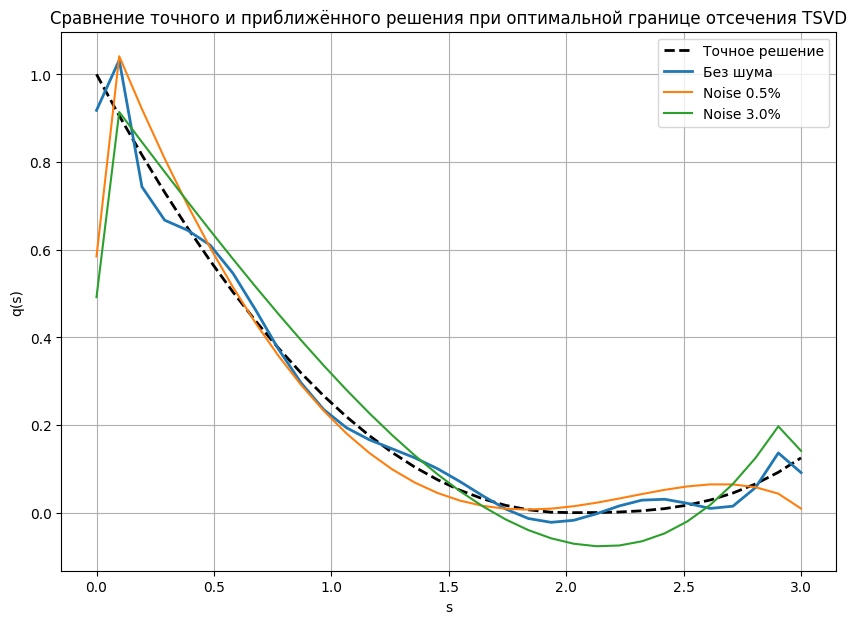

In [30]:
N_noise = 32
noise_levels = [0.005, 0.03]  # 0.5% и 3%

s_grid, w = build_weights(0, 3, N_noise)
t_grid = np.linspace(0, 1, N_noise)

A = build_A_simpson(t_grid, s_grid, w)
f_exact = compute_f_exact(t_grid, s_grid, w)

# SVD
U, svals, Vt = la.svd(A, full_matrices=False)

np.random.seed(0)
f_noisy_dict = {}
for delta in noise_levels:
    alpha = np.random.rand(N_noise)
    f_noisy_dict[delta] = f_exact + delta * alpha

noise_levels_extended = ["clean"] + noise_levels
f_noisy_dict["clean"] = f_exact.copy()

# диапазон границы отсечения сингулярынх чисел
rcond_list = np.logspace(-15, -1, 30)
errors_dict = {key: [] for key in noise_levels_extended}

for key in noise_levels_extended:
    f_in = f_noisy_dict[key]
    for rcond in rcond_list:
        bound = rcond * svals[0]
        s_inv = np.array([1/s if s > bound else 0 for s in svals])
        qN = Vt.T @ (s_inv * (U.T @ f_in))
        err = la.norm(qN - q_exact(s_grid)) / la.norm(q_exact(s_grid))
        errors_dict[key].append(err)

plt.figure(figsize=(10,6))

plt.loglog(rcond_list, errors_dict["clean"], '-o', label="Без шума")
for delta in noise_levels:
    plt.loglog(rcond_list, errors_dict[delta], '-o', label=f"Noise {delta*100:.1f}%")

plt.xlabel("Граница отсечения сингулярынх чисел для TSVD)")
plt.ylabel("Относительная ошибка")
plt.title("Ошибка TSVD в зависимости от границы отсечения сингулярных значений")
plt.grid(True, which="both")
plt.legend()
plt.show()

# Поиск оптимальной границы отсечения сингулярных числе (минимум относительный ошибки)
optimal_rcond = {}
optimal_solution = {}
optimal_error = {}

for key in noise_levels_extended:
    idx = np.argmin(errors_dict[key])
    r_opt = rcond_list[idx]
    optimal_rcond[key] = r_opt
    
    f_in = f_noisy_dict[key]
    bound = r_opt * svals[0]
    s_inv_opt = np.array([1/s if s > bound else 0 for s in svals])
    q_opt = Vt.T @ (s_inv_opt * (U.T @ f_in))
    
    optimal_solution[key] = q_opt
    optimal_error[key] = errors_dict[key][idx]

print("\n Значение границы отсечения сингулярных чсиел при минимальной относительной ошибке")
print(f"Без шума: rcond = {optimal_rcond['clean']:.3e}, error = {optimal_error['clean']:.3e}")
for delta in noise_levels:
    print(f"Noise {delta*100:.1f}%: rcond = {optimal_rcond[delta]:.3e}, error = {optimal_error[delta]:.3e}")

plt.figure(figsize=(10,7))

plt.plot(s_grid, q_exact(s_grid), "k--", linewidth=2, label="Точное решение")

plt.plot(s_grid, optimal_solution["clean"], label="Без шума", linewidth=2)

for delta in noise_levels:
    plt.plot(s_grid, optimal_solution[delta], label=f"Noise {delta*100:.1f}%")

plt.xlabel("s")
plt.ylabel("q(s)")
plt.grid(True)
plt.title("Сравнение точного и приближённого решения при оптимальной границе отсечения TSVD")
plt.legend()
#plt.xlim(0, 3)
plt.show()


4. Показать результат применения метода регуляризации А.Н.Тихонова  при разных значениях параметра регуляризации.

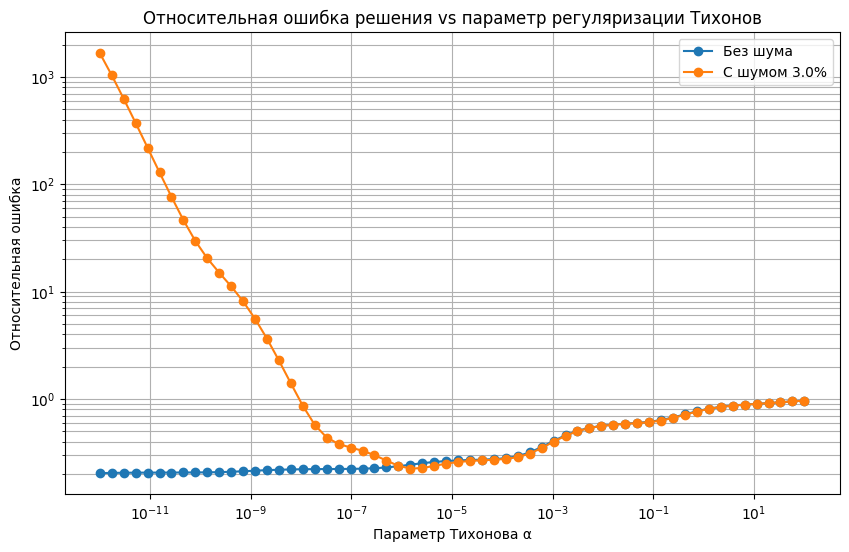

Оптимальный α (без шума): 1e-12
Оптимальный α (с шумом): 1.4773776525985127e-06


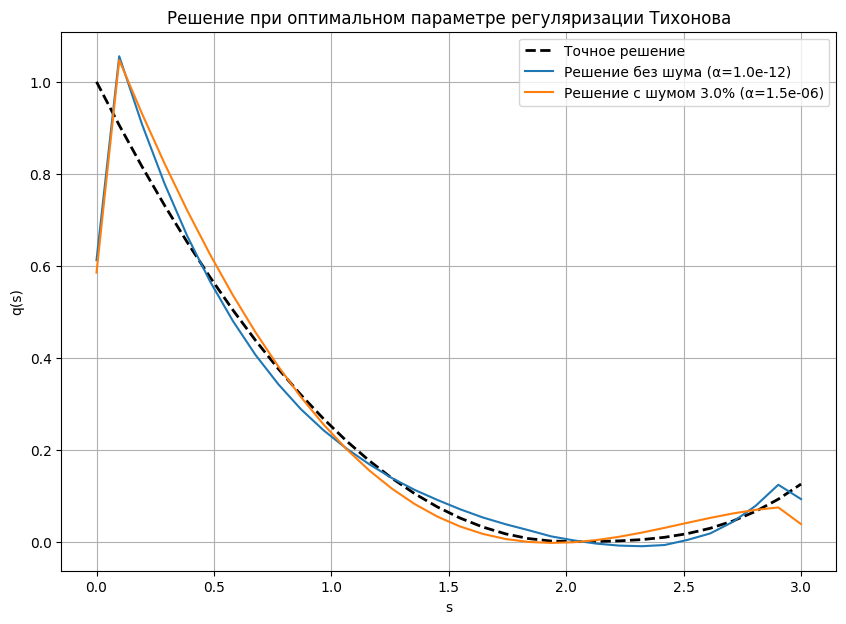

In [8]:
N_tikh = 32
s_grid, w = build_weights(0, 3, N_tikh)
t_grid = np.linspace(0, 1, N_tikh)


A = build_A_simpson(t_grid, s_grid, w)
f_exact = compute_f_exact(t_grid, s_grid, w)


noise_level = 0.03     # 3% шум
np.random.seed(0)
alpha_noise = np.random.rand(N_tikh)
f_noisy = f_exact + noise_level * alpha_noise

# Список параметров регуляризации α
alpha_list = np.logspace(-12, 2, 60)

errors_exact = []
errors_noisy = []

solutions_exact = {}
solutions_noisy = {}


for alpha in alpha_list:

    # Решение без шума
    q_alpha_exact = la.solve(
        A.T @ A + alpha * np.eye(N_tikh),
        A.T @ f_exact
    )

    # Решение с шумом
    q_alpha_noisy = la.solve(
        A.T @ A + alpha * np.eye(N_tikh),
        A.T @ f_noisy
    )

    solutions_exact[alpha] = q_alpha_exact
    solutions_noisy[alpha] = q_alpha_noisy

    err_ex = la.norm(q_alpha_exact - q_exact(s_grid)) / la.norm(q_exact(s_grid))
    err_no = la.norm(q_alpha_noisy - q_exact(s_grid)) / la.norm(q_exact(s_grid))

    errors_exact.append(err_ex)
    errors_noisy.append(err_no)



# 
plt.figure(figsize=(10,6))
plt.loglog(alpha_list, errors_exact, '-o', label="Без шума")
plt.loglog(alpha_list, errors_noisy, '-o', label=f"С шумом {noise_level*100:.1f}%")
plt.xlabel("Параметр Тихонова α")
plt.ylabel("Относительная ошибка")
plt.grid(True, which="both")
plt.title("Относительная ошибка решения vs параметр регуляризации Тихонов")
plt.legend()
plt.show()


# параметр регуляризации, доставляющий минимум относительной ошибке
alpha_opt_exact = alpha_list[np.argmin(errors_exact)]
alpha_opt_noisy = alpha_list[np.argmin(errors_noisy)]

print("Оптимальный α (без шума):", alpha_opt_exact)
print("Оптимальный α (с шумом):", alpha_opt_noisy)


plt.figure(figsize=(10,7))

plt.plot(s_grid, q_exact(s_grid), "k--", linewidth=2, label="Точное решение")

plt.plot(s_grid, solutions_exact[alpha_opt_exact],
         label=f"Решение без шума (α={alpha_opt_exact:.1e})")

plt.plot(s_grid, solutions_noisy[alpha_opt_noisy],
         label=f"Решение с шумом {noise_level*100:.1f}% (α={alpha_opt_noisy:.1e})")

plt.xlabel("s")
plt.ylabel("q(s)")
plt.grid(True)
plt.legend()
plt.title("Решение при оптимальном параметре регуляризации Тихонова")

plt.show()


5. 


=== Noise level 0.5% ===
noise norm = 1.814e-02
alpha_min_err = 2.512e-08, error = 2.169e-01, residual = 7.862e-03
alpha_min_res = 1.000e-08, residual = 7.862e-03, error = 2.338e-01
alpha_morozov = 7.943e-04, residual = 1.828e-02, error = 3.790e-01

=== Noise level 1.0% ===
noise norm = 2.802e-02
alpha_min_err = 6.310e-05, error = 2.778e-01, residual = 1.389e-02
alpha_min_res = 1.000e-08, residual = 1.364e-02, error = 2.111e+00
alpha_morozov = 1.995e-03, residual = 2.786e-02, error = 4.657e-01


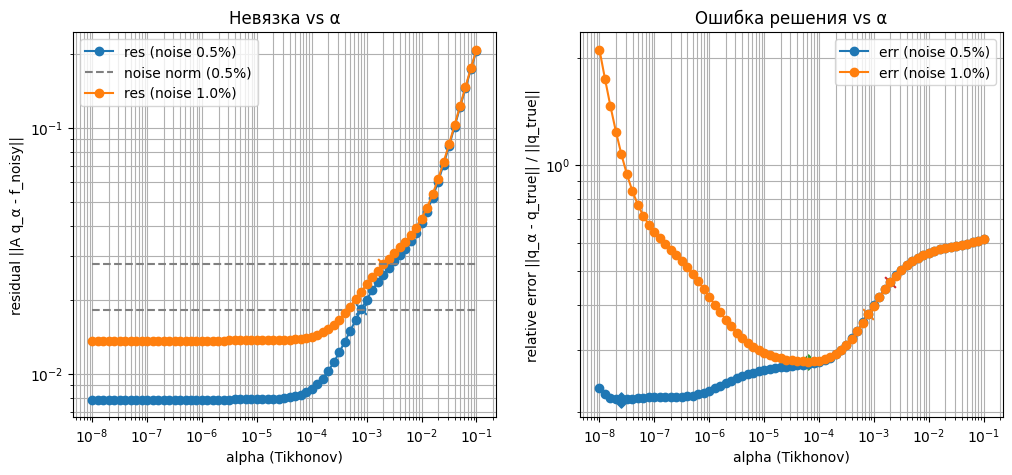


--- Summary for noise 0.5% ---
alpha_min_err = 2.512e-08: error = 2.169e-01, residual = 7.862e-03
alpha_min_res = 1.000e-08: residual = 7.862e-03, error = 2.338e-01
alpha_morozov = 7.943e-04: residual = 1.828e-02, error = 3.790e-01


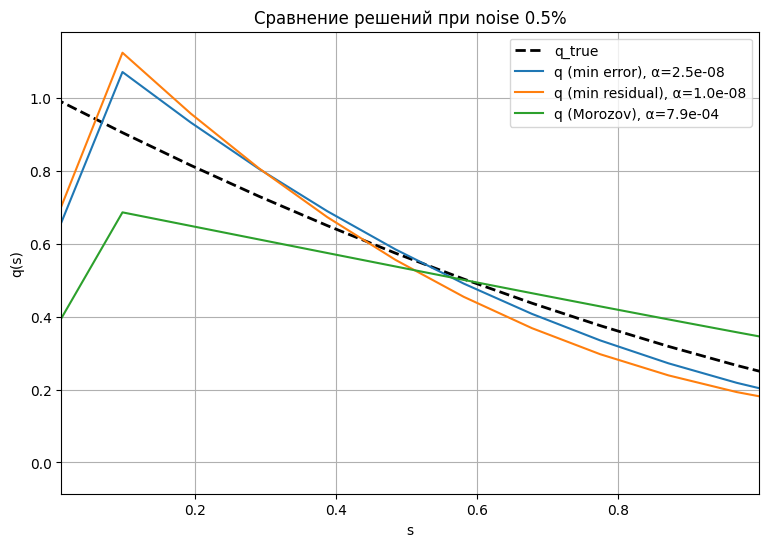


--- Summary for noise 1.0% ---
alpha_min_err = 6.310e-05: error = 2.778e-01, residual = 1.389e-02
alpha_min_res = 1.000e-08: residual = 1.364e-02, error = 2.111e+00
alpha_morozov = 1.995e-03: residual = 2.786e-02, error = 4.657e-01


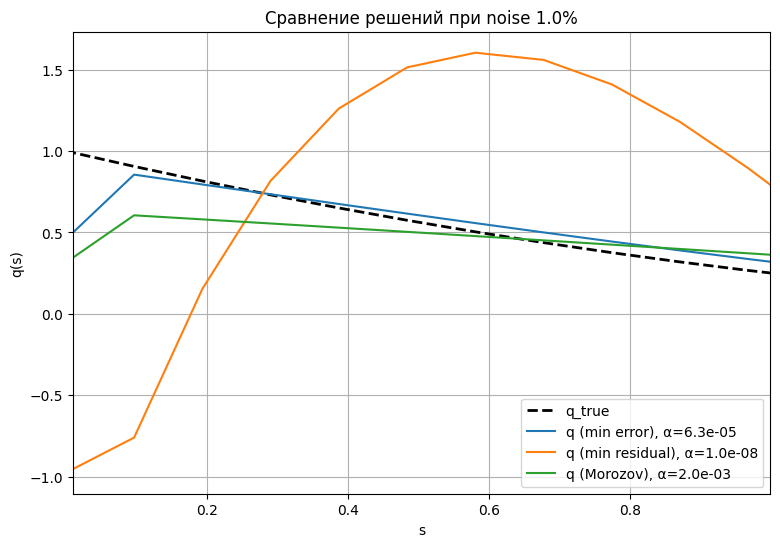

In [4]:
N = 32
noise_levels = [0.005, 0.01]  # 0.5% и 1%
np.random.seed(0)

s_grid, w = build_weights(0, 3, N)
t_grid = np.linspace(0, 1, N)
A = build_A_simpson(t_grid, s_grid, w)
f_exact = compute_f_exact(t_grid, s_grid, w)
q_true = q_exact(s_grid)

m = 10 
alphas = []
for exp in range(-8, -1):    # exp = -8, -7, ..., -2. subinterval [10^exp, 10^(exp+1))
    a_sub = np.logspace(exp, exp+1, m, endpoint=False)
    alphas.append(a_sub)
alphas = np.concatenate(alphas)
alphas = np.concatenate([alphas, np.array([1e-1])])  # дописать последнюю точку 1e-1


# ---------------------------
# Для каждого уровня шума: считаем q_alpha, residual, error
# ---------------------------
results = {}

for delta in noise_levels:

    alpha_rand = np.random.rand(N)
    f_noisy = f_exact + delta * alpha_rand
    noise_norm = la.norm(f_noisy - f_exact)

    errors = []
    residuals = []
    solutions = []

    ATA = A.T @ A
    ATf_noisy = A.T @ f_noisy

    for alpha in alphas:

        q_alpha = la.solve(ATA + alpha * np.eye(N), ATf_noisy)
        solutions.append(q_alpha)

        res = la.norm(A @ q_alpha - f_noisy)
        residuals.append(res)

        err = la.norm(q_alpha - q_true) / la.norm(q_true)
        errors.append(err)

    errors = np.array(errors)
    residuals = np.array(residuals)
    solutions = np.array(solutions)

    idx_min_err = np.argmin(errors)
    alpha_min_err = alphas[idx_min_err]

    idx_min_res = np.argmin(residuals)
    alpha_min_res = alphas[idx_min_res]

    # Морозов: ищем alpha, при котором residual примерно равен noise_norm
    # выбираем индекс, дающий минимальную abs(res - noise_norm)
    idx_mor = np.argmin(np.abs(residuals - noise_norm))
    alpha_morozov = alphas[idx_mor]

    results[delta] = {
        "f_noisy": f_noisy,
        "noise_norm": noise_norm,
        "alphas": alphas,
        "errors": errors,
        "residuals": residuals,
        "solutions": solutions,
        "alpha_min_err": alpha_min_err,
        "alpha_min_res": alpha_min_res,
        "alpha_morozov": alpha_morozov,
        "idx_min_err": idx_min_err,
        "idx_min_res": idx_min_res,
        "idx_mor": idx_mor
    }

    print(f"\n=== Noise level {delta*100:.1f}% ===")
    print(f"noise norm = {noise_norm:.3e}")
    print(f"alpha_min_err = {alpha_min_err:.3e}, error = {errors[idx_min_err]:.3e}, residual = {residuals[idx_min_err]:.3e}")
    print(f"alpha_min_res = {alpha_min_res:.3e}, residual = {residuals[idx_min_res]:.3e}, error = {errors[idx_min_res]:.3e}")
    print(f"alpha_morozov = {alpha_morozov:.3e}, residual = {residuals[idx_mor]:.3e}, error = {errors[idx_mor]:.3e}")


plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
for delta in noise_levels:
    data = results[delta]
    plt.loglog(data["alphas"], data["residuals"], '-o', label=f"res (noise {delta*100:.1f}%)")

    plt.hlines(data["noise_norm"], xmin=data["alphas"][0], xmax=data["alphas"][-1],
               colors='gray', linestyles='dashed', label=f"noise norm ({delta*100:.1f}%)" if delta==noise_levels[0] else None)
    plt.scatter(data["alpha_morozov"], data["residuals"][data["idx_mor"]], s=60, marker='x')
plt.xlabel("alpha (Tikhonov)")
plt.ylabel("residual ||A q_α - f_noisy||")
plt.title("Невязка vs α")
plt.grid(True, which='both')
plt.legend()

plt.subplot(1,2,2)
for delta in noise_levels:
    data = results[delta]
    plt.loglog(data["alphas"], data["errors"], '-o', label=f"err (noise {delta*100:.1f}%)")

    plt.scatter(data["alpha_min_err"], data["errors"][data["idx_min_err"]], s=60, marker='D')
    plt.scatter(data["alpha_morozov"], data["errors"][data["idx_mor"]], s=60, marker='x')
plt.xlabel("alpha (Tikhonov)")
plt.ylabel("relative error ||q_α - q_true|| / ||q_true||")
plt.title("Ошибка решения vs α")
plt.grid(True, which='both')
plt.legend()
plt.show()


for delta in noise_levels:
    data = results[delta]
    idx_err = data["idx_min_err"]
    idx_res = data["idx_min_res"]
    idx_mor = data["idx_mor"]

    q_err = data["solutions"][idx_err]
    q_res = data["solutions"][idx_res]
    q_mor = data["solutions"][idx_mor]

    print(f"\n--- Summary for noise {delta*100:.1f}% ---")
    print(f"alpha_min_err = {data['alpha_min_err']:.3e}: error = {data['errors'][idx_err]:.3e}, residual = {data['residuals'][idx_err]:.3e}")
    print(f"alpha_min_res = {data['alpha_min_res']:.3e}: residual = {data['residuals'][idx_res]:.3e}, error = {data['errors'][idx_res]:.3e}")
    print(f"alpha_morozov = {data['alpha_morozov']:.3e}: residual = {data['residuals'][idx_mor]:.3e}, error = {data['errors'][idx_mor]:.3e}")

    plt.figure(figsize=(9,6))
    plt.plot(s_grid, q_true, 'k--', linewidth=2, label='q_true')
    plt.plot(s_grid, q_err, label=f'q (min error), α={data["alpha_min_err"]:.1e}')
    plt.plot(s_grid, q_res, label=f'q (min residual), α={data["alpha_min_res"]:.1e}')
    plt.plot(s_grid, q_mor, label=f'q (Morozov), α={data["alpha_morozov"]:.1e}')
    plt.xlabel('s')
    plt.ylabel('q(s)')
    plt.title(f'Сравнение решений при noise {delta*100:.1f}%')
    plt.xlim(0.01, 0.999)
    plt.grid(True)
    plt.legend()
    plt.show()


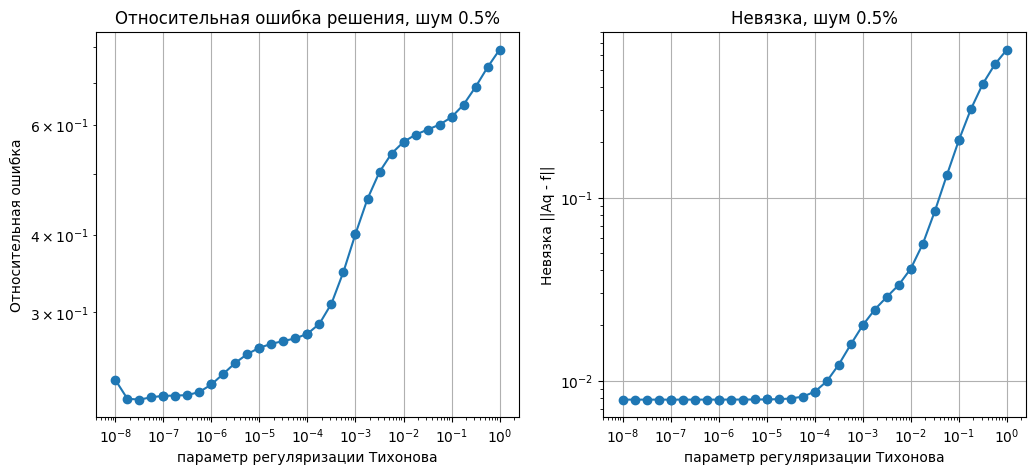

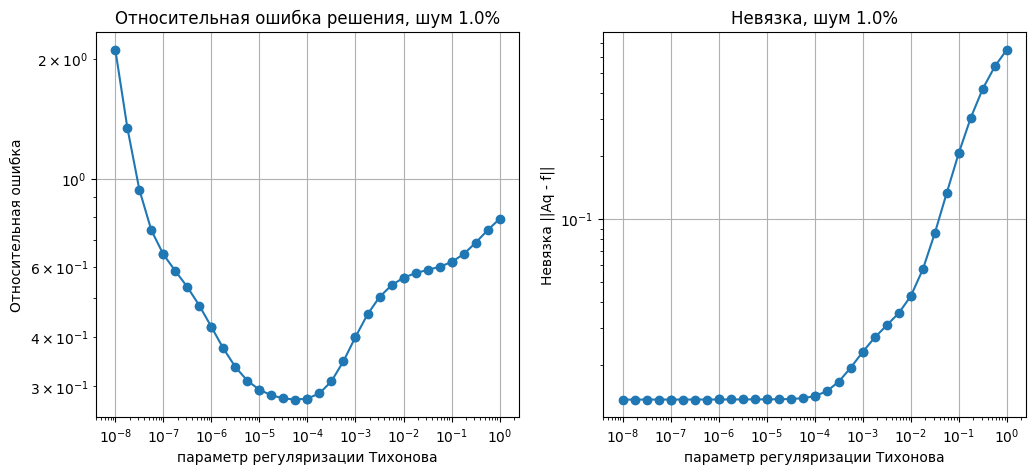


=== Шум 0.5% ===
α минимальной ошибки   = 3.162e-08
α минимальной невязки   = 1.000e-08
α по Морозову           = 1.778e-03

=== Шум 1.0% ===
α минимальной ошибки   = 5.623e-05
α минимальной невязки   = 1.000e-08
α по Морозову           = 1.000e-02


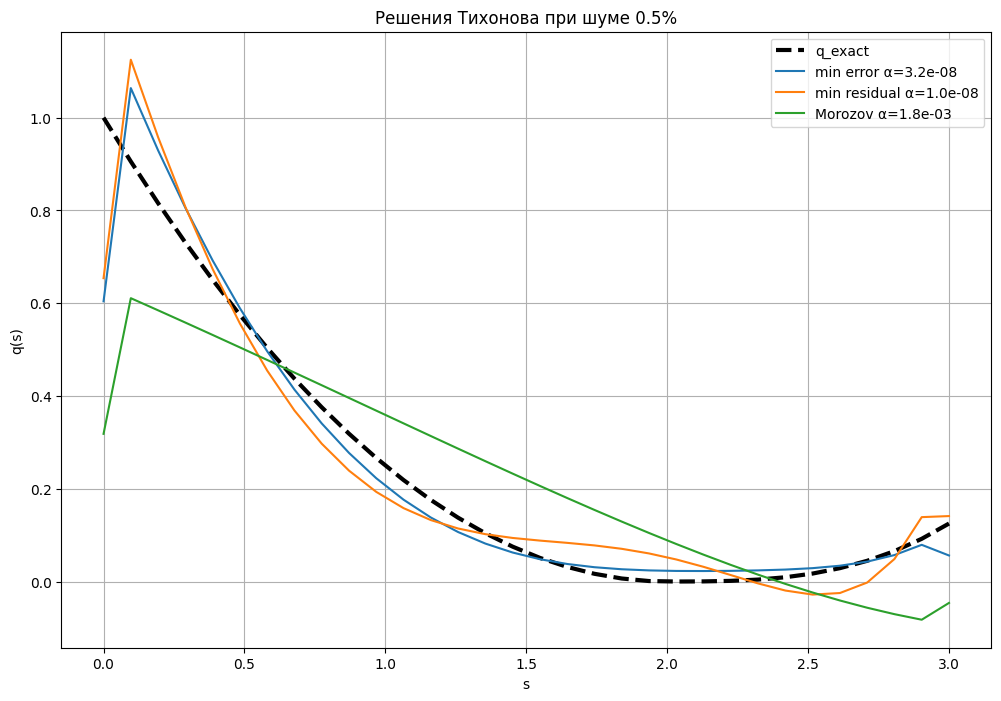

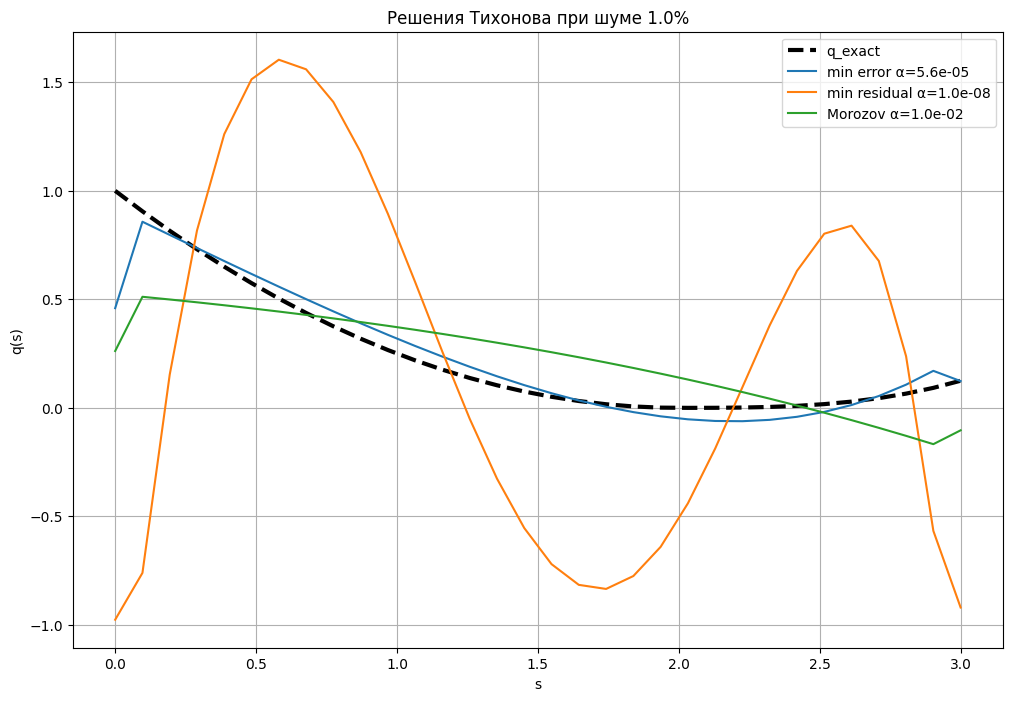

In [7]:
N = 32
noise_levels = [0.005, 0.01]  # 0.5% и 1%


m = 5
alpha_list = []
for k in range(-8, 0):           # подинтервалы 10^k ... 10^(k+1)
    alpha_list.extend(np.logspace(k, k+1, m))
alpha_list = np.array(alpha_list)


s_grid, w = build_weights(0, 3, N)
t_grid = np.linspace(0, 1, N)

A = build_A_simpson(t_grid, s_grid, w)
f_exact = compute_f_exact(t_grid, s_grid, w)
q_ex = q_exact(s_grid)

U, svals, Vt = la.svd(A, full_matrices=False)

np.random.seed(0)
f_noisy_dict = {}
for delta in noise_levels:
    alpha_noise = np.random.rand(N)
    f_noisy_dict[delta] = f_exact + delta * alpha_noise


def tikhonov_solution(alpha, f_noisy):
    """
    q_alpha = V diag(s_i/(s_i^2+alpha)) U^T f
    """
    filt = svals / (svals**2 + alpha)
    return Vt.T @ (filt * (U.T @ f_noisy))


errors = {delta: [] for delta in noise_levels}
residuals = {delta: [] for delta in noise_levels}

for delta in noise_levels:
    f_noisy = f_noisy_dict[delta]

    for alpha in alpha_list:
        q_alpha = tikhonov_solution(alpha, f_noisy)

        # ошибка решения
        err = la.norm(q_alpha - q_ex) / la.norm(q_ex)
        errors[delta].append(err)

        # невязка
        res = la.norm(A @ q_alpha - f_noisy)
        residuals[delta].append(res)


# графики ошибка vs  альфа, невязка vs альфа
for delta in noise_levels:
    plt.figure(figsize=(12,5))

    # ошибка
    plt.subplot(1,2,1)
    plt.loglog(alpha_list, errors[delta], '-o')
    plt.xlabel("параметр регуляризации Тихонова")
    plt.ylabel("Относительная ошибка")
    plt.title(f"Относительная ошибка решения, шум {delta*100:.1f}%")
    plt.grid(True)

    # невязка
    plt.subplot(1,2,2)
    plt.loglog(alpha_list, residuals[delta], '-o')
    plt.xlabel("параметр регуляризации Тихонова")
    plt.ylabel("Невязка ||Aq - f||")
    plt.title(f"Невязка, шум {delta*100:.1f}%")
    plt.grid(True)

    plt.show()



chosen_alpha = {}

for delta in noise_levels:
    f_noisy = f_noisy_dict[delta]

    # минимальная ошибка
    idx_err = np.argmin(errors[delta])
    alpha_min_err = alpha_list[idx_err]

    # минимальная невязка
    idx_res = np.argmin(residuals[delta])
    alpha_min_res = alpha_list[idx_res]

    # Морозов
    target = delta * la.norm(f_exact)
    idx_morozov = np.argmin(np.abs(np.array(residuals[delta]) - target))
    alpha_morozov = alpha_list[idx_morozov]

    chosen_alpha[delta] = (alpha_min_err, alpha_min_res, alpha_morozov)

    print(f"\n=== Шум {delta*100:.1f}% ===")
    print(f"α минимальной ошибки   = {alpha_min_err:.3e}")
    print(f"α минимальной невязки   = {alpha_min_res:.3e}")
    print(f"α по Морозову           = {alpha_morozov:.3e}")


for delta in noise_levels:
    f_noisy = f_noisy_dict[delta]
    alpha_min_err, alpha_min_res, alpha_morozov = chosen_alpha[delta]

    plt.figure(figsize=(12,8))

    # точное
    plt.plot(s_grid, q_ex, 'k--', label="q_exact", linewidth=3)

    # три решения
    q1 = tikhonov_solution(alpha_min_err, f_noisy)
    q2 = tikhonov_solution(alpha_min_res, f_noisy)
    q3 = tikhonov_solution(alpha_morozov, f_noisy)

    plt.plot(s_grid, q1, label=f"min error α={alpha_min_err:.1e}")
    plt.plot(s_grid, q2, label=f"min residual α={alpha_min_res:.1e}")
    plt.plot(s_grid, q3, label=f"Morozov α={alpha_morozov:.1e}")

    plt.title(f"Решения Тихонова при шуме {delta*100:.1f}%")
    plt.xlabel("s")
    plt.ylabel("q(s)")
    plt.grid(True)
    plt.legend()
    plt.show()
